# 1. Loading Dataset and Pretraining Model

In [44]:
# Standard library imports
import gc
import io
import os
import shutil
import time
import warnings
from collections import Counter
from pathlib import Path

# Third-party imports
import kagglehub
import numpy as np
import pandas as pd
import PIL
import requests
import torch
from tqdm import tqdm

# Image processing and transformations
from torchvision import transforms
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomAdjustSharpness,
    RandomHorizontalFlip,
    RandomResizedCrop,
    RandomRotation,
    ColorJitter,
    Resize,
    ToTensor
)

# Deep learning frameworks
from torch.utils.data import DataLoader
from datasets import Dataset, Image, ClassLabel

# Transformers and model-specific imports
from transformers import (
    AutoImageProcessor,
    AutoModelForImageClassification,
    DefaultDataCollator,
    Trainer,
    TrainingArguments,
    ViTForImageClassification,
    ViTImageProcessor
)

# Machine learning utilities
import accelerate
import evaluate
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    roc_auc_score
)

# Visualization
import matplotlib.pyplot as plt

# Configuration
warnings.filterwarnings("ignore")

In [ ]:
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'}

# Load and process a cat image for testing
cat_url = "https://upload.wikimedia.org/wikipedia/commons/3/3a/Cat03.jpg"  # Example cat image
cat_response = requests.get(cat_url, headers=headers)
cat_image = PIL.Image.open(io.BytesIO(cat_response.content))

image_processor = AutoImageProcessor.from_pretrained("dima806/cat_breed_image_detection")
cat_breed_model = AutoModelForImageClassification.from_pretrained("dima806/cat_breed_image_detection")

inputs = image_processor(images=cat_image, return_tensors="pt")

outputs = cat_breed_model(**inputs)
logits = outputs.logits

# Get top 3 predictions with probabilities
probabilities = torch.nn.functional.softmax(logits, dim=-1)
top3_prob, top3_idx = torch.topk(probabilities, 3)

print("Top 3 Predicted Cat Breeds:")
for i in range(3):
    class_idx = top3_idx[0][i].item()
    class_name = cat_breed_model.config.id2label[class_idx]
    accuracy = top3_prob[0][i].item() * 100
    print(f"{i+1}. {class_name}: {accuracy:.2f}%")

Top 3 Predicted Cat Breeds:
1. Manx: 24.49%
2. Maine Coon: 17.49%
3. American Bobtail: 9.23%


In [5]:
print("CAT BREED MODEL - Available Classes")
print(f"Total number of cat breeds: {len(cat_breed_model.config.id2label)}")
print("\nAll cat breeds the model can predict:")
for idx, label in sorted(cat_breed_model.config.id2label.items()):
    print(f"  {idx:3d}. {label}")

CAT BREED MODEL - Available Classes
Total number of cat breeds: 48

All cat breeds the model can predict:
    0. Abyssinian
    1. American Bobtail
    2. American Curl
    3. American Shorthair
    4. Applehead Siamese
    5. Balinese
    6. Bengal
    7. Birman
    8. Bombay
    9. British Shorthair
   10. Burmese
   11. Calico
   12. Cornish Rex
   13. Devon Rex
   14. Dilute Calico
   15. Dilute Tortoiseshell
   16. Domestic Long Hair
   17. Domestic Medium Hair
   18. Domestic Short Hair
   19. Egyptian Mau
   20. Exotic Shorthair
   21. Extra-Toes Cat - Hemingway Polydactyl
   22. Havana
   23. Himalayan
   24. Japanese Bobtail
   25. Maine Coon
   26. Manx
   27. Munchkin
   28. Nebelung
   29. Norwegian Forest
   30. Oriental Short Hair
   31. Persian
   32. Ragamuffin
   33. Ragdoll
   34. Russian Blue
   35. Scottish Fold
   36. Siamese
   37. Siberian
   38. Snowshoe
   39. Sphynx
   40. Tabby
   41. Tiger
   42. Tonkinese
   43. Torbie
   44. Tortoiseshell
   45. Turkish An

In [6]:
NEW_BREEDS = [
    "Chartreux",
    "Chausie", 
    "Khao Manee",
    "Kurilian Bobtail",
    "LaPerm",
    "Neva Masquerade",
    "Ocicat",
    "Peterbald",
    "Savannah",
    "Selkirk Rex",
    "Serengeti",
    "Singapura",
]

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("almanaqibmahmooddar/37-cats-breeds-dataset")

print("Path to dataset files:", path)

# Current working directory
dst = os.getcwd()

# Copy only the new breed folders to current working directory
dst_images = os.path.join(dst, 'images')
os.makedirs(dst_images, exist_ok=True)

source_images = os.path.join(path, 'images')

for breed in NEW_BREEDS:
    source_breed_folder = os.path.join(source_images, breed)
    dest_breed_folder = os.path.join(dst_images, breed)
    
    if os.path.exists(source_breed_folder):
        if not os.path.exists(dest_breed_folder):
            shutil.copytree(source_breed_folder, dest_breed_folder)
            num_images = len([f for f in os.listdir(dest_breed_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
            print(f"Copied {breed}: {num_images} images")
        else:
            print(f"Skipped {breed}: already exists")
    else:
        print(f"Warning: {breed} not found in dataset")

print(f"\nNew breed folders copied to: {dst_images}")


Path to dataset files: C:\Users\ferdi\.cache\kagglehub\datasets\almanaqibmahmooddar\37-cats-breeds-dataset\versions\1
Copied Chartreux: 1000 images
Copied Chartreux: 1000 images
Copied Chausie: 1000 images
Copied Chausie: 1000 images
Copied Khao Manee: 1000 images
Copied Khao Manee: 1000 images
Copied Kurilian Bobtail: 1000 images
Copied Kurilian Bobtail: 1000 images
Copied LaPerm: 1000 images
Copied LaPerm: 1000 images
Copied Neva Masquerade: 1000 images
Copied Neva Masquerade: 1000 images
Copied Ocicat: 1000 images
Copied Ocicat: 1000 images
Copied Peterbald: 1000 images
Copied Peterbald: 1000 images
Copied Savannah: 1000 images
Copied Savannah: 1000 images
Copied Selkirk Rex: 1000 images
Copied Selkirk Rex: 1000 images
Copied Serengeti: 1000 images
Copied Serengeti: 1000 images
Copied Singapura: 1000 images

New breed folders copied to: d:\NYU\Fall25\MACHINE LEARNING\Project\breed-specific-care-recommendation\images
Copied Singapura: 1000 images

New breed folders copied to: d:\NYU\

In [8]:
import hashlib
from collections import defaultdict
from pathlib import Path

def get_file_hash(file_path):
    """Calculate MD5 hash of a file to identify duplicates"""
    hash_md5 = hashlib.md5()
    with open(file_path, "rb") as f:
        for chunk in iter(lambda: f.read(4096), b""):
            hash_md5.update(chunk)
    return hash_md5.hexdigest()

def find_and_remove_duplicates(images_dir='images'):
    """
    Find and remove duplicate images in breed folders
    
    Args:
        images_dir: Root directory containing breed folders
    
    Returns:
        dict: Statistics about duplicates found and removed
    """
    images_path = Path(images_dir)
    
    if not images_path.exists():
        print(f"Error: Directory {images_dir} not found")
        return None
    
    stats = {
        'total_images': 0,
        'duplicates_found': 0,
        'duplicates_removed': 0,
        'space_saved_mb': 0,
        'breeds_processed': 0,
        'details': []
    }
    
    print("DUPLICATE IMAGE DETECTION AND REMOVAL")
    
    # Get all subdirectories (breed folders)
    breed_folders = [f for f in images_path.iterdir() if f.is_dir()]
    
    if not breed_folders:
        print(f"No breed folders found in {images_dir}")
        return stats
    
    for breed_folder in breed_folders:
        breed = breed_folder.name
        
        # Get all image files
        image_files = list(breed_folder.glob('*.*'))
        image_files = [f for f in image_files if f.suffix.lower() in ['.jpg', '.jpeg', '.png', '.gif', '.bmp']]
        
        if not image_files:
            print(f"Skipping {breed}: no images found")
            continue
        
        stats['total_images'] += len(image_files)
        stats['breeds_processed'] += 1
        
        # Find duplicates by hash
        hash_to_files = defaultdict(list)
        
        print(f"\nProcessing {breed}...")
        for img_file in image_files:
            try:
                file_hash = get_file_hash(img_file)
                hash_to_files[file_hash].append(img_file)
            except Exception as e:
                print(f"Error reading {img_file.name}: {e}")
        
        # Identify duplicates (keep first file, remove rest)
        breed_duplicates = 0
        breed_space_saved = 0
        
        for file_hash, files in hash_to_files.items():
            if len(files) > 1:
                # Keep the first file (usually the original)
                original = files[0]
                duplicates = files[1:]
                
                breed_duplicates += len(duplicates)
                
                for dup_file in duplicates:
                    file_size_mb = dup_file.stat().st_size / (1024 * 1024)
                    breed_space_saved += file_size_mb
                    
                    try:
                        dup_file.unlink()
                        print(f"DELETED: {dup_file.name} (duplicate of {original.name}) - {file_size_mb:.2f} MB")
                        stats['duplicates_removed'] += 1
                    except Exception as e:
                        print(f"Failed to delete {dup_file.name}: {e}")
        
        stats['duplicates_found'] += breed_duplicates
        stats['space_saved_mb'] += breed_space_saved
        
        if breed_duplicates > 0:
            print(f"Found {breed_duplicates} duplicate(s) in {breed} ({breed_space_saved:.2f} MB)")
            stats['details'].append({
                'breed': breed,
                'total_images': len(image_files),
                'duplicates': breed_duplicates,
                'space_saved_mb': breed_space_saved
            })
        else:
            print(f"No duplicates in {breed}")
    
    print(f"\n{'='*50}")
    print(f"Breeds processed: {stats['breeds_processed']}")
    print(f"Total images scanned: {stats['total_images']}")
    print(f"Duplicates found: {stats['duplicates_found']}")
    print(f"Duplicates removed: {stats['duplicates_removed']}")
    print(f"Space saved: {stats['space_saved_mb']:.2f} MB")
    
    if stats['details']:
        print("\nBreeds with duplicates:")
        for detail in stats['details']:
            print(f"- {detail['breed']}: {detail['duplicates']} duplicate(s) / {detail['total_images']} total ({detail['space_saved_mb']:.2f} MB)")
    
    return stats

In [9]:
find_and_remove_duplicates(images_dir='images')

DUPLICATE IMAGE DETECTION AND REMOVAL

Processing Chartreux...
No duplicates in Chartreux

Processing Chausie...
No duplicates in Chausie

Processing Khao Manee...
No duplicates in Khao Manee

Processing Kurilian Bobtail...
No duplicates in Kurilian Bobtail

Processing LaPerm...
No duplicates in LaPerm

Processing Neva Masquerade...
No duplicates in Neva Masquerade

Processing Ocicat...
No duplicates in Ocicat

Processing Peterbald...
No duplicates in Peterbald

Processing Savannah...
No duplicates in Savannah

Processing Selkirk Rex...
No duplicates in Selkirk Rex

Processing Serengeti...
No duplicates in Serengeti

Processing Singapura...
No duplicates in Singapura

Breeds processed: 12
Total images scanned: 1351
Duplicates found: 0
Duplicates removed: 0
Space saved: 0.00 MB


{'total_images': 1351,
 'duplicates_found': 0,
 'duplicates_removed': 0,
 'space_saved_mb': 0,
 'breeds_processed': 12,
 'details': []}

# 2. Image Pre-Processing and Background Removal
Step:
* Background removal
* Cropping with alpha channel
* Resize to 224x224

In [13]:
if torch.cuda.is_available():
    print(f"Number of GPUs: {torch.cuda.device_count()}")
    print(f"GPU name: {torch.cuda.get_device_name(torch.cuda.current_device())}")
else:
    print("No GPU available")


Number of GPUs: 1
GPU name: NVIDIA GeForce RTX 3050 Ti Laptop GPU


In [14]:
import numpy as np
from PIL import Image
from rembg import remove, new_session
from pathlib import Path
import torch

_bg_removal_session = None

def get_bg_removal_session():
    global _bg_removal_session
    if _bg_removal_session is None:
        if torch.cuda.is_available():
            print(f"GPU detected: {torch.cuda.get_device_name(0)}")
            print(f"CUDA version: {torch.version.cuda}")
            print(f"Using GPU for background removal.")
            _bg_removal_session = new_session("u2net") 
        else:
            print("No GPU detected, using CPU for background removal")
            _bg_removal_session = new_session("u2net")
    return _bg_removal_session

def preprocess_image_advanced(image_path, output_size=(224, 224), use_gpu=False):
    # Load and convert image
    img = Image.open(image_path).convert('RGB')

    # Background removal
    if use_gpu:
        session = get_bg_removal_session()
        img = remove(img, session=session)
    else:
        img = remove(img)

    # Cropping with alpha channel
    if img.mode == 'RGBA':
        alpha = np.array(img.split()[3])
        rows = np.any(alpha > 0, axis=1)
        cols = np.any(alpha > 0, axis=0)
        
        if rows.any() and cols.any():
            y_min, y_max = np.where(rows)[0][[0, -1]]
            x_min, x_max = np.where(cols)[0][[0, -1]]
            
            height = y_max - y_min
            width = x_max - x_min
            
            # Calculate center of the subject
            center_y = (y_min + y_max) // 2
            center_x = (x_min + x_max) // 2
            
            # Determine the larger dimension to make a square crop
            max_dim = max(height, width)
            
            # Add minimal padding (2%) to the square dimension
            crop_size = int(max_dim * 1.02)
            
            # Calculate crop boundaries centered on the subject
            half_crop = crop_size // 2
            crop_y_min = max(0, center_y - half_crop)
            crop_y_max = min(img.height, center_y + half_crop)
            crop_x_min = max(0, center_x - half_crop)
            crop_x_max = min(img.width, center_x + half_crop)
            
            img = img.crop((crop_x_min, crop_y_min, crop_x_max, crop_y_max))

        background = Image.new('RGB', img.size, (128, 128, 128))  # Neutral gray background
        background.paste(img, mask=img.split()[3])
        img = background
    
    #Resize 
    img.thumbnail((output_size[0], output_size[1]), Image.LANCZOS)
    
    #Center
    final_img = Image.new('RGB', output_size, (128, 128, 128))  # Neutral gray background
    paste_x = (output_size[0] - img.width) // 2
    paste_y = (output_size[1] - img.height) // 2
    final_img.paste(img, (paste_x, paste_y))
    
    return final_img

In [15]:
def preprocess_new_breeds_only(df, new_breeds_list, output_dir='preprocessed_new_breeds', use_gpu=False, skip_existing=True):
    output_path = Path(output_dir)
    output_path.mkdir(exist_ok=True)
    
    df_new_breeds = df[df['label'].isin(new_breeds_list)].copy()
    
    print(f"Processing {len(df_new_breeds)} images from {len(new_breeds_list)} new breeds.")
    print(f"Breeds: {', '.join(new_breeds_list)}")
    print(f"Output directory: {output_dir}")
    print(f"Using GPU: {use_gpu}")
    print(f"Skip existing: {skip_existing}")
    
    if use_gpu:
        print("\nInitializing GPU-accelerated background removal")
        get_bg_removal_session()
    
    processed_files = []
    failed_files = []
    skipped_files = []
    start_time = time.time()
    
    print("\nPress Ctrl+C to pause. Run again with skip_existing=True to resume.\n")
    
    try:
        for idx, row in tqdm(df_new_breeds.iterrows(), total=len(df_new_breeds), desc="Preprocessing new breeds"):
            img_path = row['image']
            label = row['label']
            
            label_dir = output_path / label
            label_dir.mkdir(exist_ok=True)
            
            output_file = label_dir / Path(img_path).name
            
            if skip_existing and output_file.exists():
                processed_files.append(str(output_file))
                skipped_files.append(str(output_file))
                continue
            
            try:
                img = preprocess_image_advanced(img_path, use_gpu=use_gpu)
                img.save(output_file)
                processed_files.append(str(output_file))
                
            except Exception as e:
                print(f"\nError processing {img_path}: {e}")
                failed_files.append(img_path)
                processed_files.append(img_path)  # Keep original if processing fails
    
    except KeyboardInterrupt:
        print("PAUSED BY USER (Ctrl+C)")
        print(f"Processed so far: {len(processed_files) - len(skipped_files) - len(failed_files)} images")
        print(f"To resume: Run this cell again with skip_existing=True")
        raise
    
    elapsed_time = time.time() - start_time
    
    print("PREPROCESSING COMPLETE")
    print(f"Successfully processed: {len(processed_files) - len(failed_files) - len(skipped_files)} images")
    print(f"Skipped (already exists): {len(skipped_files)} images")
    print(f"Failed: {len(failed_files)} images")
    print(f"Total time: {elapsed_time/60:.2f} minutes ({elapsed_time/len(df_new_breeds):.2f}s per image)")
    print(f"Saved to: {output_dir}/")
    
    if failed_files:
        print(f"\nFailed files:")
        for f in failed_files[:]:  
            print(f"   - {f}")
    
    df_new_breeds['preprocessed_image'] = processed_files
    
    return df_new_breeds

In [ ]:
# use https://huggingface.co/docs/datasets/image_load for reference

# Import necessary libraries
image_dict = {}

# Define the list of file names
from pathlib import Path
from tqdm import tqdm
import os

# Initialize empty lists to store file names and labels
file_names = []
labels = []

# Iterate through all image files in the specified directory
for file in tqdm(sorted(Path('images/').glob('*/*.*'))):
    if str(file).endswith('pg') or str(file).endswith('png'): 
        label = str(file).split(os.sep)[-2]  # Extract the label from the file path
        # Only include files from the specified breeds
        if label in NEW_BREEDS:
            file_names.append(str(file))  # Add the file path to the list
            labels.append(label)  # Add the label to the list

# Print the total number of file names and labels
print(len(file_names), len(labels), len(set(labels)))

# Create a pandas dataframe from the collected file names and labels
df = pd.DataFrame.from_dict({"image": file_names, "label": labels})


In [ ]:
df_new_breeds_preprocessed = preprocess_new_breeds_only(
    df=df,
    new_breeds_list=NEW_BREEDS,
    output_dir='preprocessed_new_breeds',
    use_gpu=False,
    skip_existing=True
)

print("\nSample of preprocessed data:")
print(df_new_breeds_preprocessed[['label', 'image', 'preprocessed_image']].head())

Processing 1036 images from 12 new breeds.
Breeds: Chartreux, Chausie, Khao Manee, Kurilian Bobtail, LaPerm, Neva Masquerade, Ocicat, Peterbald, Savannah, Selkirk Rex, Serengeti, Singapura
Output directory: preprocessed_new_breeds
Using GPU: False
Skip existing: True

Press Ctrl+C to pause. Run again with skip_existing=True to resume.



Preprocessing new breeds: 100%|██████████| 1036/1036 [20:51<00:00,  1.21s/it]

PREPROCESSING COMPLETE
Successfully processed: 1036 images
Skipped (already exists): 0 images
Failed: 0 images
Total time: 20.85 minutes (1.21s per image)
Saved to: preprocessed_new_breeds/

Sample of preprocessed data:
       label                                              image  \
0  Chartreux  images\Chartreux\001bf5595769468c9198e51f5136f...   
1  Chartreux  images\Chartreux\004f765eb57049f6acc3152e5fc4f...   
2  Chartreux  images\Chartreux\006028b4a8744277b8db7953d6ead...   
3  Chartreux  images\Chartreux\00d05f299027442d8b9ae1cd4bfaa...   
4  Chartreux  images\Chartreux\012abf24be3b4bf4a6f6543d125a2...   

                                  preprocessed_image  
0  preprocessed_new_breeds\Chartreux\001bf5595769...  
1  preprocessed_new_breeds\Chartreux\004f765eb570...  
2  preprocessed_new_breeds\Chartreux\006028b4a874...  
3  preprocessed_new_breeds\Chartreux\00d05f299027...  
4  preprocessed_new_breeds\Chartreux\012abf24be3b...  


# 3. Data Loading & Sampler

In [155]:
# use https://huggingface.co/docs/datasets/image_load for reference

# Import necessary libraries
image_dict = {}

# Define the list of file names
from pathlib import Path
from tqdm import tqdm
import os

# Initialize empty lists to store file names and labels
file_names = []
labels = []

# Iterate through all image files in the specified directory
for file in tqdm(sorted(Path('preprocessed_new_breeds/').glob('*/*.*'))):
    if str(file).endswith('pg') or str(file).endswith('png'): 
        label = str(file).split(os.sep)[-2]  # Extract the label from the file path
        # Only include files from the specified breeds
        if label in NEW_BREEDS:
            file_names.append(str(file))  # Add the file path to the list
            labels.append(label)  # Add the label to the list

# Print the total number of file names and labels
print(len(file_names), len(labels), len(set(labels)))

# Create a pandas dataframe from the collected file names and labels
df = pd.DataFrame.from_dict({"image": file_names, "label": labels})


100%|██████████| 1036/1036 [00:00<00:00, 96609.43it/s]

1036 1036 12


In [156]:
df['label'].unique()

array(['Chartreux', 'Chausie', 'Khao Manee', 'Kurilian Bobtail', 'LaPerm',
       'Neva Masquerade', 'Ocicat', 'Peterbald', 'Savannah',
       'Selkirk Rex', 'Serengeti', 'Singapura'], dtype=object)

In [157]:
df['label'].value_counts()

label
Savannah            128
Ocicat               98
Singapura            95
Neva Masquerade      92
LaPerm               91
Peterbald            90
Chartreux            86
Chausie              80
Selkirk Rex          79
Serengeti            78
Khao Manee           69
Kurilian Bobtail     50
Name: count, dtype: int64

In [158]:
# random undersampling of a majority class
# rus = RandomUnderSampler(random_state=83, sampling_strategy='majority')
# y = df[['label']]
# df = df.drop(['label'], axis=1)
# df, y_resampled = rus.fit_resample(df, y)
# del y
# df['label'] = y_resampled
# del y_resampled

# random oversampling of all minority classes to 5645 samples each
y = df[['label']]
df = df.drop(['label'], axis=1)
ros = RandomOverSampler(random_state=83, sampling_strategy={label: 5645 for label in y['label'].unique()})
df, y_resampled = ros.fit_resample(df, y)
del y
df['label'] = y_resampled
del y_resampled
gc.collect()

print(df.shape)
print(df['label'].value_counts())

(67740, 2)
label
Chartreux           5645
Chausie             5645
Khao Manee          5645
Kurilian Bobtail    5645
LaPerm              5645
Neva Masquerade     5645
Ocicat              5645
Peterbald           5645
Savannah            5645
Selkirk Rex         5645
Serengeti           5645
Singapura           5645
Name: count, dtype: int64


In [159]:
from sklearn.model_selection import train_test_split

# TRAINING DATA: Split NEW breeds only (60% train, 40% for later validation)
train_df_new, test_df_new = train_test_split(
    df,  # Only NEW breeds
    test_size=0.4, 
    stratify=df['label'],
    random_state=42
)

print(f"Total images: {len(df)}")
print(f"Training images: {len(train_df_new)} (60%)")
print(f"Testing images: {len(test_df_new)} (40%)")
print(f"\nImages per breed in training set:")
print(train_df_new['label'].value_counts().sort_index())
print(f"\nImages per breed in test set:")
print(test_df_new['label'].value_counts().sort_index())

Total images: 67740
Training images: 40644 (60%)
Testing images: 27096 (40%)

Images per breed in training set:
label
Chartreux           3387
Chausie             3387
Khao Manee          3387
Kurilian Bobtail    3387
LaPerm              3387
Neva Masquerade     3387
Ocicat              3387
Peterbald           3387
Savannah            3387
Selkirk Rex         3387
Serengeti           3387
Singapura           3387
Name: count, dtype: int64

Images per breed in test set:
label
Chartreux           2258
Chausie             2258
Khao Manee          2258
Kurilian Bobtail    2258
LaPerm              2258
Neva Masquerade     2258
Ocicat              2258
Peterbald           2258
Savannah            2258
Selkirk Rex         2258
Serengeti           2258
Singapura           2258
Name: count, dtype: int64


In [160]:
# use https://huggingface.co/docs/datasets/image_load for reference

# Import necessary libraries
image_dict = {}

# Define the list of file names
from pathlib import Path
from tqdm import tqdm
import os
# Initialize empty lists to store file names and labels
file_names = []
labels = []
# Iterate through all image files in the specified directory
for file in tqdm(sorted((Path('cat-breeds-dataset/images/').glob('*/*.*'))) + sorted((Path('catbreedsrefined-7k/CatBreedsRefined-v2/').glob('*/*.*')))):
    if str(file).endswith('pg') or str(file).endswith('png'): 
        file_names.append(str(file))  # Add the file path to the list
        label = str(file).split(os.sep)[-2]  # Extract the breed folder name
        labels.append(label)  # Add the label to the list

# Print the total number of file names and labels
print(len(file_names), len(labels), len(set(labels)))

# Create a pandas dataframe from the collected file names and labels
df_original = pd.DataFrame.from_dict({"image": file_names, "label": labels})

100%|██████████| 133607/133607 [00:00<00:00, 410671.51it/s]

133607 133607 69


In [161]:
df_original['label'].unique()

array(['Abyssinian', 'American Bobtail', 'American Curl',
       'American Shorthair', 'American Wirehair', 'Applehead Siamese',
       'Balinese', 'Bengal', 'Birman', 'Bombay', 'British Shorthair',
       'Burmese', 'Burmilla', 'Calico', 'Canadian Hairless', 'Chartreux',
       'Chausie', 'Chinchilla', 'Cornish Rex', 'Cymric', 'Devon Rex',
       'Dilute Calico', 'Dilute Tortoiseshell', 'Domestic Long Hair',
       'Domestic Medium Hair', 'Domestic Short Hair', 'Egyptian Mau',
       'Exotic Shorthair', 'Extra-Toes Cat - Hemingway Polydactyl',
       'Havana', 'Himalayan', 'Japanese Bobtail', 'Javanese', 'Korat',
       'LaPerm', 'Maine Coon', 'Manx', 'Munchkin', 'Nebelung',
       'Norwegian Forest Cat', 'Ocicat', 'Oriental Long Hair',
       'Oriental Short Hair', 'Oriental Tabby', 'Persian', 'Pixiebob',
       'Ragamuffin', 'Ragdoll', 'Russian Blue', 'Scottish Fold',
       'Selkirk Rex', 'Siamese', 'Siberian', 'Silver', 'Singapura',
       'Snowshoe', 'Somali', 'Sphynx - Hairless 

In [162]:
df_original['label'].value_counts().head(50)

label
Domestic Short Hair                      53027
American Shorthair                        5645
Domestic Medium Hair                      5482
Domestic Long Hair                        4499
Persian                                   4368
Tortoiseshell                             3963
Calico                                    3468
Torbie                                    3396
Siamese                                   3238
Dilute Calico                             3230
Tuxedo                                    3181
Dilute Tortoiseshell                      3152
Ragdoll                                   3019
Tabby                                     3012
Bengal                                    2827
Manx                                      2409
Tiger                                     2256
Russian Blue                              2220
Bombay                                    2185
Maine Coon                                1768
Snowshoe                                  1625
America

In [163]:
# use only top-50 of most common labels
print(df_original.shape, df_original[df_original['label'].isin(df_original['label'].value_counts().head(50).index)].shape)
df_original = df_original[df_original['label'].isin(df_original['label'].value_counts().head(50).index)]

(133607, 2) (132741, 2)


In [164]:
# create a list of redundant labels
redundant_labels_dict = {'Norwegian Forest Cat': 'Norwegian Forest', 'Sphynx - Hairless Cat': 'Sphynx'}
df_original['label'] = df_original['label'].replace(redundant_labels_dict)

# Create a list of unique labels by converting 'labels' to a set and then back to a list
labels_list = sorted(list(set(df_original['label'])))

In [165]:
df_original['label'].unique()

array(['Abyssinian', 'American Bobtail', 'American Curl',
       'American Shorthair', 'Applehead Siamese', 'Balinese', 'Bengal',
       'Birman', 'Bombay', 'British Shorthair', 'Burmese', 'Calico',
       'Cornish Rex', 'Devon Rex', 'Dilute Calico',
       'Dilute Tortoiseshell', 'Domestic Long Hair',
       'Domestic Medium Hair', 'Domestic Short Hair', 'Egyptian Mau',
       'Exotic Shorthair', 'Extra-Toes Cat - Hemingway Polydactyl',
       'Havana', 'Himalayan', 'Japanese Bobtail', 'Maine Coon', 'Manx',
       'Munchkin', 'Nebelung', 'Norwegian Forest', 'Oriental Short Hair',
       'Persian', 'Ragamuffin', 'Ragdoll', 'Russian Blue',
       'Scottish Fold', 'Siamese', 'Siberian', 'Snowshoe', 'Sphynx',
       'Tabby', 'Tiger', 'Tonkinese', 'Torbie', 'Tortoiseshell',
       'Turkish Angora', 'Turkish Van', 'Tuxedo'], dtype=object)

In [166]:
# random undersampling of a majority class
rus = RandomUnderSampler(random_state=83, sampling_strategy='majority')
y = df_original[['label']]
df_original = df_original.drop(['label'], axis=1)
df_original, y_resampled = rus.fit_resample(df_original, y)
del y
df_original['label'] = y_resampled
del y_resampled
# random oversampling of all minority classes
y = df_original[['label']]
df_original = df_original.drop(['label'], axis=1)
ros = RandomOverSampler(random_state=83)
df_original, y_resampled = ros.fit_resample(df_original, y)
del y
df_original['label'] = y_resampled
del y_resampled
gc.collect()

print(df_original.shape)

(270960, 2)


In [167]:
df_original['label'].value_counts().head(50)

label
Abyssinian                               5645
American Bobtail                         5645
American Curl                            5645
American Shorthair                       5645
Applehead Siamese                        5645
Balinese                                 5645
Bengal                                   5645
Birman                                   5645
Bombay                                   5645
British Shorthair                        5645
Burmese                                  5645
Calico                                   5645
Cornish Rex                              5645
Devon Rex                                5645
Dilute Calico                            5645
Dilute Tortoiseshell                     5645
Domestic Long Hair                       5645
Domestic Medium Hair                     5645
Domestic Short Hair                      5645
Egyptian Mau                             5645
Exotic Shorthair                         5645
Extra-Toes Cat - Hemingway P

In [168]:
from sklearn.model_selection import train_test_split

# Split the original dataset into train (60%) and test (40%)
train_df_original, test_df_original = train_test_split(
    df_original, 
    test_size=0.4, 
    stratify=df_original['label'],
    random_state=42
)

print(f"Total images: {len(df_original)}")
print(f"Testing images: {len(test_df_original)} (40%)")
print(f"\nImages per breed in train set:")
print(train_df_original['label'].value_counts().sort_index())
print(f"\nImages per breed in test set:")
print(test_df_original['label'].value_counts().sort_index())

Total images: 270960
Testing images: 108384 (40%)

Images per breed in train set:
label
Abyssinian                               3387
American Bobtail                         3387
American Curl                            3387
American Shorthair                       3387
Applehead Siamese                        3387
Balinese                                 3387
Bengal                                   3387
Birman                                   3387
Bombay                                   3387
British Shorthair                        3387
Burmese                                  3387
Calico                                   3387
Cornish Rex                              3387
Devon Rex                                3387
Dilute Calico                            3387
Dilute Tortoiseshell                     3387
Domestic Long Hair                       3387
Domestic Medium Hair                     3387
Domestic Short Hair                      3387
Egyptian Mau                          

# 4. Fine-tuning Cat Breed Model with New Breeds

In [174]:
test_df_combined = pd.concat([test_df_original, test_df_new], ignore_index=True)

# Assign to standard variable names
train_df = train_df_new  # Training: NEW breeds only
test_df = test_df_combined  # Validation: ALL breeds

print(f"\nTraining will use {len(train_df)} images from NEW {train_df['label'].nunique()} breeds")
print(f"Validation will test on {len(test_df)} images from ALL {test_df['label'].nunique()} breeds")


Training will use 40644 images from NEW 12 breeds
Validation will test on 135480 images from ALL 60 breeds


In [175]:
# Rehearsal strategy: balanced sampling (equal samples per breed)
REHEARSAL_RATIO = 0.7

num_original_samples = int(len(train_df_new) * REHEARSAL_RATIO)

print("APPLYING REHEARSAL STRATEGY (BALANCED SAMPLING)")
print(f"\nCurrent training data: {len(train_df_new)} images (NEW breeds only)")

# Balanced sampling: equal number of samples from each original breed
original_breeds_list = train_df_original['label'].unique()
num_breeds = len(original_breeds_list)
samples_per_breed = num_original_samples // num_breeds  # Integer division

# Calculate actual total (may be slightly less due to integer division)
actual_original_samples = samples_per_breed * num_breeds

print(f"Target: {num_original_samples} images from original breeds ({REHEARSAL_RATIO*100:.0f}% ratio)")
print(f"Actual: {actual_original_samples} images (balanced: {samples_per_breed} samples × {num_breeds} breeds)")
if actual_original_samples < num_original_samples:
    print(f"Note: {num_original_samples - actual_original_samples} images dropped due to integer division for perfect balance")

sampled_dfs = []
for breed in original_breeds_list:
    breed_df = train_df_original[train_df_original['label'] == breed]
    replace = len(breed_df) < samples_per_breed
    breed_sample = breed_df.sample(
        n=min(samples_per_breed, len(breed_df)), 
        replace=replace, 
        random_state=42
    )
    sampled_dfs.append(breed_sample)

train_df_original_sample = pd.concat(sampled_dfs, ignore_index=True)

# Combine and shuffle
train_df_mixed = pd.concat([train_df_new, train_df_original_sample], ignore_index=True)
train_df_mixed = train_df_mixed.sample(frac=1, random_state=42).reset_index(drop=True)

# Update training dataframe
train_df = train_df_mixed

# Display summary
print(f"\nNew training data: {len(train_df)} images")
print(f"- New breeds: {len(train_df_new)} ({len(train_df_new)/len(train_df)*100:.1f}%)")
print(f"- Original breeds: {len(train_df_original_sample)} ({len(train_df_original_sample)/len(train_df)*100:.1f}%)")
print(f"- Total breeds: {train_df['label'].nunique()}")

# Show per-breed statistics for both groups
breed_dist_original = train_df_original_sample['label'].value_counts()
breed_dist_new = train_df_new['label'].value_counts()

print(f"\nPer-breed sample distribution:")
print(f"  Original breeds ({len(breed_dist_original)} breeds): Min={breed_dist_original.min()}, Max={breed_dist_original.max()}, Mean={breed_dist_original.mean():.1f}")
print(f"  New breeds ({len(breed_dist_new)} breeds):      Min={breed_dist_new.min()}, Max={breed_dist_new.max()}, Mean={breed_dist_new.mean():.1f}")

APPLYING REHEARSAL STRATEGY (BALANCED SAMPLING)

Current training data: 40644 images (NEW breeds only)
Target: 28450 images from original breeds (70% ratio)
Actual: 28416 images (balanced: 592 samples × 48 breeds)
Note: 34 images dropped due to integer division for perfect balance

New training data: 69060 images
- New breeds: 40644 (58.9%)
- Original breeds: 28416 (41.1%)
- Total breeds: 60

Per-breed sample distribution:
  Original breeds (48 breeds): Min=592, Max=592, Mean=592.0
  New breeds (12 breeds):      Min=3387, Max=3387, Mean=3387.0


In [176]:
# Get original cat breed labels and combine with new breeds
original_cat_labels = list(cat_breed_model.config.id2label.values())
print(f"Original model has {len(original_cat_labels)} breeds")
print(f"Adding {len(NEW_BREEDS)} new breeds")

all_cat_breeds = original_cat_labels.copy()

# Only add new breeds that don't already exist
for breed in NEW_BREEDS:
    if breed not in all_cat_breeds:
        all_cat_breeds.append(breed)

print(f"\nTotal breeds after expansion: {len(all_cat_breeds)}")

# Create label mappings (original breeds keep their indices 0-35, new breeds get 36+)
label2id = {label: idx for idx, label in enumerate(all_cat_breeds)}
id2label = {idx: label for label, idx in label2id.items()}

print(f"\nOriginal breeds: indices 0-{len(original_cat_labels)-1}")
print(f"New breeds added: indices {len(original_cat_labels)}-{len(all_cat_breeds)-1}")
print(f"\nNew breed indices:")
for breed in NEW_BREEDS:
    if breed in label2id:
        print(f"  {label2id[breed]}: {breed}")

Original model has 48 breeds
Adding 12 new breeds

Total breeds after expansion: 60

Original breeds: indices 0-47
New breeds added: indices 48-59

New breed indices:
  48: Chartreux
  49: Chausie
  50: Khao Manee
  51: Kurilian Bobtail
  52: LaPerm
  53: Neva Masquerade
  54: Ocicat
  55: Peterbald
  56: Savannah
  57: Selkirk Rex
  58: Serengeti
  59: Singapura


In [177]:
# Create Hugging Face datasets from the dataframes
from datasets import Dataset, ClassLabel, Image as HFImage

def create_hf_dataset(df, label2id):
    """Convert dataframe to Hugging Face Dataset"""
    # Add numeric labels with the correct column name 'labels' (not 'label_id')
    df = df.copy()
    df['labels'] = df['label'].map(label2id)
    
    # Create dataset with only the columns we need
    dataset = Dataset.from_pandas(df[['image', 'labels']], preserve_index=False)
    
    # Cast image column to Image type
    dataset = dataset.cast_column('image', HFImage())
    
    # Cast labels to ClassLabel
    dataset = dataset.cast_column('labels', ClassLabel(names=list(label2id.keys())))
    
    return dataset

# Create train and test datasets
train_dataset = create_hf_dataset(train_df, label2id)
test_dataset = create_hf_dataset(test_df, label2id)

print(f"Training dataset: {len(train_dataset)} images")
print(f"Test dataset: {len(test_dataset)} images")
print(f"\nDataset features: {train_dataset.features}")

Casting the dataset: 100%|██████████| 135480/135480 [00:00<00:00, 7050439.92 examples/s]

Training dataset: 69060 images
Test dataset: 135480 images

Dataset features: {'image': Image(mode=None, decode=True), 'labels': ClassLabel(names=['Abyssinian', 'American Bobtail', 'American Curl', 'American Shorthair', 'Applehead Siamese', 'Balinese', 'Bengal', 'Birman', 'Bombay', 'British Shorthair', 'Burmese', 'Calico', 'Cornish Rex', 'Devon Rex', 'Dilute Calico', 'Dilute Tortoiseshell', 'Domestic Long Hair', 'Domestic Medium Hair', 'Domestic Short Hair', 'Egyptian Mau', 'Exotic Shorthair', 'Extra-Toes Cat - Hemingway Polydactyl', 'Havana', 'Himalayan', 'Japanese Bobtail', 'Maine Coon', 'Manx', 'Munchkin', 'Nebelung', 'Norwegian Forest', 'Oriental Short Hair', 'Persian', 'Ragamuffin', 'Ragdoll', 'Russian Blue', 'Scottish Fold', 'Siamese', 'Siberian', 'Snowshoe', 'Sphynx', 'Tabby', 'Tiger', 'Tonkinese', 'Torbie', 'Tortoiseshell', 'Turkish Angora', 'Turkish Van', 'Tuxedo', 'Chartreux', 'Chausie', 'Khao Manee', 'Kurilian Bobtail', 'LaPerm', 'Neva Masquerade', 'Ocicat', 'Peterbald', 'Sa

In [178]:
# Calculate class weights to handle imbalance between original and new breeds
import torch
import numpy as np

print("="*70)
print("CLASS WEIGHT CALCULATION")
print("="*70)

# Get sample counts per breed in training data
breed_counts = train_df['label'].value_counts()

# Calculate total samples
total_samples = len(train_df)

# Calculate class weights using inverse frequency
# Weight = total_samples / (num_classes * samples_per_class)
num_classes = len(breed_counts)

class_weights = {}
for breed, count in breed_counts.items():
    weight = total_samples / (num_classes * count)
    class_weights[breed] = weight

# Convert to tensor format for PyTorch (ordered by label2id)
class_weights_tensor = torch.tensor([
    class_weights[id2label[i]] for i in range(len(id2label))
], dtype=torch.float32)

print(f"\nTotal samples: {total_samples}")
print(f"Number of classes: {num_classes}")

# Show statistics
print(f"\n{'='*70}")
print("WEIGHT STATISTICS BY BREED GROUP")
print("="*70)

# Original breeds weights
original_weights = [class_weights[breed] for breed in original_breeds_list if breed in class_weights]
print(f"\nORIGINAL BREEDS ({len(original_breeds_list)} breeds):")
print(f"  Sample count per breed: {breed_counts[original_breeds_list[0]]}")
print(f"  Weight per breed: {original_weights[0]:.4f}")
print(f"  Min weight: {min(original_weights):.4f}")
print(f"  Max weight: {max(original_weights):.4f}")
print(f"  Mean weight: {np.mean(original_weights):.4f}")

# New breeds weights
new_weights = [class_weights[breed] for breed in NEW_BREEDS if breed in class_weights]
print(f"\nNEW BREEDS ({len(NEW_BREEDS)} breeds):")
print(f"  Sample count per breed: {breed_counts[NEW_BREEDS[0]]}")
print(f"  Weight per breed: {new_weights[0]:.4f}")
print(f"  Min weight: {min(new_weights):.4f}")
print(f"  Max weight: {max(new_weights):.4f}")
print(f"  Mean weight: {np.mean(new_weights):.4f}")

# Show weight ratio
weight_ratio = original_weights[0] / new_weights[0]
print(f"\n{'='*70}")
print("WEIGHT RATIO ANALYSIS")
print("="*70)
print(f"Original breed weight / New breed weight = {weight_ratio:.2f}x")
print(f"\nInterpretation:")
print(f"  • Original breeds get {weight_ratio:.2f}x more weight in the loss function")
print(f"  • This compensates for having {breed_counts[NEW_BREEDS[0]] / breed_counts[original_breeds_list[0]]:.2f}x fewer samples")
print(f"  • Prevents model from being biased towards new breeds during training")

print(f"\n{'='*70}")
print("SAMPLE DETAILED WEIGHTS (First 10 classes)")
print("="*70)
for i in range(min(60, len(id2label))):
    breed = id2label[i]
    weight = class_weights_tensor[i].item()
    count = breed_counts[breed]
    breed_type = "NEW" if breed in NEW_BREEDS else "ORIGINAL"
    print(f"Class {i:2d} [{breed_type:8s}] {breed:25s}: Weight={weight:.4f}, Samples={count}")

print(f"\n{'='*70}")
print("✓ Class weights calculated successfully!")
print("="*70)

CLASS WEIGHT CALCULATION

Total samples: 69060
Number of classes: 60

WEIGHT STATISTICS BY BREED GROUP

ORIGINAL BREEDS (48 breeds):
  Sample count per breed: 592
  Weight per breed: 1.9443
  Min weight: 1.9443
  Max weight: 1.9443
  Mean weight: 1.9443

NEW BREEDS (12 breeds):
  Sample count per breed: 3387
  Weight per breed: 0.3398
  Min weight: 0.3398
  Max weight: 0.3398
  Mean weight: 0.3398

WEIGHT RATIO ANALYSIS
Original breed weight / New breed weight = 5.72x

Interpretation:
  • Original breeds get 5.72x more weight in the loss function
  • This compensates for having 5.72x fewer samples
  • Prevents model from being biased towards new breeds during training

SAMPLE DETAILED WEIGHTS (First 10 classes)
Class  0 [ORIGINAL] Abyssinian               : Weight=1.9443, Samples=592
Class  1 [ORIGINAL] American Bobtail         : Weight=1.9443, Samples=592
Class  2 [ORIGINAL] American Curl            : Weight=1.9443, Samples=592
Class  3 [ORIGINAL] American Shorthair       : Weight=1.9

In [179]:
# Load image processor and prepare transforms
image_processor = AutoImageProcessor.from_pretrained("dima806/cat_breed_image_detection")

# Get the size (height) of the ViT model's input images
size = image_processor.size["height"]
print("Size: ", size)

normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)

# Simple preprocessing for both train and validation (no additional augmentation needed)
train_transforms = Compose([
    RandomHorizontalFlip(p=0.5),
    RandomRotation(degrees=15, fill=(128, 128, 128)),  # Neutral gray fill for rotated corners
    RandomResizedCrop(size=224, scale=(0.85, 1.0), ratio=(0.9, 1.1)),
    ColorJitter(
        brightness=0.2,
        contrast=0.2,
        saturation=0.15,
        hue=0.05
    ),
    Resize(image_processor.size["height"]),
    CenterCrop(image_processor.size["height"]),
    ToTensor(),
    normalize,
])

val_transforms = Compose([
    Resize(image_processor.size["height"]),
    CenterCrop(image_processor.size["height"]),
    ToTensor(),
    normalize,
])

def train_transform(example_batch):
    """Apply train transforms to a batch"""
    example_batch["pixel_values"] = [
        train_transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    # Remove the original image column to avoid dtype inference issues
    example_batch.pop("image", None)
    return example_batch

def val_transform(example_batch):
    """Apply validation transforms to a batch"""
    example_batch["pixel_values"] = [
        val_transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    # Remove the original image column to avoid dtype inference issues
    example_batch.pop("image", None)
    return example_batch

# Apply transforms to datasets
train_dataset.set_transform(train_transform)
test_dataset.set_transform(val_transform)

print("Transforms applied successfully!")

Size:  224
Transforms applied successfully!


In [180]:
# Load the base model and expand classifier head from 48 to 60 classes
from transformers import ViTForImageClassification
import torch

# STEP 1: Load the original model to get pretrained classifier weights
print("Loading original model...")
original_model = AutoModelForImageClassification.from_pretrained("dima806/cat_breed_image_detection")
num_original_classes = original_model.config.num_labels
print(f"Original model classes: {num_original_classes}")

# STEP 2: Load the expanded model (randomly initialized classifier)
num_new_classes = len(all_cat_breeds)
num_added_classes = num_new_classes - num_original_classes
print(f"\nExpanding model to {num_new_classes} classes...")
base_model = AutoModelForImageClassification.from_pretrained(
    "dima806/cat_breed_image_detection",
    num_labels=num_new_classes,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True  # This allows expanding the classifier layer
)

# STEP 3: Transfer original classifier weights to the expanded model
print(f"\nTransferring original {num_original_classes} breed classifier weights...")
with torch.no_grad():
    # Copy weight matrix for original classes
    base_model.classifier.weight[:num_original_classes, :] = original_model.classifier.weight.clone()
    # Copy bias for original classes
    base_model.classifier.bias[:num_original_classes] = original_model.classifier.bias.clone()

print(f"✓ Successfully transferred original {num_original_classes} breed weights")
print(f"✓ New {num_added_classes} breed weights remain randomly initialized (will be trained)")

# Clean up original model to free memory
del original_model
import gc
gc.collect()

# FREEZE THE BASE MODEL (Feature Extractor) - Preserve original breed knowledge
# This prevents catastrophic forgetting of the original breeds
print("\nFreezing base model (ViT encoder) to preserve original breed knowledge...")
for param in base_model.vit.parameters():
    param.requires_grad = False

# UNFREEZE THE CLASSIFIER HEAD - Allow learning for new breeds
print("Unfreezing classifier head to learn new breeds...")
for param in base_model.classifier.parameters():
    param.requires_grad = True

# Count trainable vs frozen parameters
trainable_params = sum(p.numel() for p in base_model.parameters() if p.requires_grad)
frozen_params = sum(p.numel() for p in base_model.parameters() if not p.requires_grad)
total_params = trainable_params + frozen_params

print(f"\nModel loaded successfully!")
print(f"Number of labels: {base_model.config.num_labels}")
print(f"Model architecture: {base_model.config.model_type}")
print(f"\nClassifier head output size: {base_model.classifier.out_features}")
print(f"\n{'='*60}")
print("PARAMETER FREEZE STRATEGY:")
print(f"{'='*60}")
print(f"Total parameters:     {total_params:,}")
print(f"Frozen parameters:    {frozen_params:,} ({frozen_params/total_params*100:.1f}%)")
print(f"Trainable parameters: {trainable_params:,} ({trainable_params/total_params*100:.1f}%)")
print(f"\n✓ Original {num_original_classes} breeds: Knowledge preserved (frozen weights)")
print(f"✓ New {num_added_classes} breeds: Will be learned (trainable classifier)")
print(f"{'='*60}")

Loading original model...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at dima806/cat_breed_image_detection and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([48]) in the checkpoint and torch.Size([60]) in the model instantiated
- classifier.weight: found shape torch.Size([48, 768]) in the checkpoint and torch.Size([60, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Original model classes: 48

Expanding model to 60 classes...

Transferring original 48 breed classifier weights...
✓ Successfully transferred original 48 breed weights
✓ New 12 breed weights remain randomly initialized (will be trained)

Freezing base model (ViT encoder) to preserve original breed knowledge...
Unfreezing classifier head to learn new breeds...

Model loaded successfully!
Number of labels: 60
Model architecture: vit

Classifier head output size: 60

PARAMETER FREEZE STRATEGY:
Total parameters:     85,844,796
Frozen parameters:    85,798,656 (99.9%)
Trainable parameters: 46,140 (0.1%)

✓ Original 48 breeds: Knowledge preserved (frozen weights)
✓ New 12 breeds: Will be learned (trainable classifier)


In [181]:
# Define metrics for evaluation
import numpy as np
import evaluate

accuracy_metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    """Compute accuracy and other metrics during evaluation"""
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    
    return {
        "accuracy": accuracy["accuracy"],
    }

print("Metrics function defined!")

Metrics function defined!


In [183]:
# Set up training arguments with Windows-compatible settings (OPTIMIZED FOR SPEED)
from transformers import TrainingArguments

model_name = "cat-breed-60-classes-rehearsal_preprocessed_new_breeds"
output_dir = f"./models/{model_name}"

training_args = TrainingArguments(
    output_dir=output_dir,
    remove_unused_columns=False,
    
    # Evaluate and save every epoch to track progress
    eval_strategy="epoch",  # Evaluate after each epoch
    save_strategy="epoch",  # Save checkpoint after each epoch
    
    # SPEED OPTIMIZATION: Larger batch size for fewer iterations
    per_device_train_batch_size=64,  # Doubled from 32 to 64 (faster if you have RAM)
    per_device_eval_batch_size=64,  # Match train batch size
    gradient_accumulation_steps=1,  # No accumulation needed with large batch

    # SPEED OPTIMIZATION: Fewer epochs (classifier converges fast)
    num_train_epochs=3,  # Training with rehearsal data
    learning_rate=5e-4,  # Good LR for classifier-only training
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    logging_dir=f"{output_dir}/logs",
    logging_steps=50,  # Log less frequently to reduce overhead
    save_total_limit=2,  # Keep only 2 best checkpoints to save disk space
    fp16=torch.cuda.is_available(),  # Enable if GPU available for faster training
    report_to="none",  # Disable wandb/tensorboard
    use_cpu=not torch.cuda.is_available(),  # Explicitly use CPU if no GPU
    ddp_find_unused_parameters=False,  # Disable DDP unused parameters
    warmup_ratio=0.1,  # Add warmup for better convergence
    lr_scheduler_type="cosine",  # Cosine learning rate decay
    dataloader_num_workers=0,  # CRITICAL: Must be 0 on Windows to avoid PartialState errors
    dataloader_persistent_workers=False,  # Disable persistent workers
    dataloader_pin_memory=False,  # Disable pin memory to avoid state issues
    
    # PREVENT SLOWDOWN OVER TIME
    gradient_checkpointing=False,  # Disable to avoid memory accumulation
    max_grad_norm=1.0,  # Clip gradients to prevent numerical instability
)

print("="*70)
print("TRAINING ARGUMENTS CONFIGURED (WITH REHEARSAL STRATEGY)")
print("="*70)
print(f"Output directory: {output_dir}")
print(f"Using GPU: {torch.cuda.is_available()}")
print(f"Number of epochs: {training_args.num_train_epochs}")
print(f"Batch size: {training_args.per_device_train_batch_size}")
print(f"Learning rate: {training_args.learning_rate}")
print(f"LR scheduler: {training_args.lr_scheduler_type} with {training_args.warmup_ratio*100:.0f}% warmup")
print(f"Evaluation: After each epoch (track train/val loss and accuracy)")
print(f"Mixed precision (fp16): {training_args.fp16}")
print(f"\nIMPORTANT: dataloader_num_workers=0 to prevent Windows PartialState errors")
print(f"\nTRAINING WITH REHEARSAL STRATEGY:")
print(f"   • Frozen ViT encoder: Preserves visual feature extraction")
print(f"   • Training data: Mixed original + new breeds (prevents catastrophic forgetting)")
print(f"   • Rehearsal ratio: {REHEARSAL_RATIO*100:.0f}% original breeds")
print("="*70)

TRAINING ARGUMENTS CONFIGURED (WITH REHEARSAL STRATEGY)
Output directory: ./models/cat-breed-60-classes-rehearsal_preprocessed_new_breeds
Using GPU: True
Number of epochs: 3
Batch size: 64
Learning rate: 0.0005
LR scheduler: cosine with 10% warmup
Evaluation: After each epoch (track train/val loss and accuracy)
Mixed precision (fp16): True

IMPORTANT: dataloader_num_workers=0 to prevent Windows PartialState errors

TRAINING WITH REHEARSAL STRATEGY:
   • Frozen ViT encoder: Preserves visual feature extraction
   • Training data: Mixed original + new breeds (prevents catastrophic forgetting)
   • Rehearsal ratio: 70% original breeds


In [184]:
# Create custom Trainer with weighted loss function
from transformers import Trainer
import torch.nn as nn

class WeightedLossTrainer(Trainer):
    """
    Custom Trainer that applies class weights to the loss function
    to handle class imbalance during training
    """
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights
        
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        """
        Compute weighted cross-entropy loss
        
        **kwargs added to handle additional parameters from newer Transformers versions
        (e.g., num_items_in_batch)
        """
        labels = inputs.pop("labels")
        
        # Forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")
        
        # Move class weights to the same device as logits
        if self.class_weights is not None:
            weights = self.class_weights.to(logits.device)
            # Compute weighted cross-entropy loss
            loss_fct = nn.CrossEntropyLoss(weight=weights)
        else:
            # Standard cross-entropy loss
            loss_fct = nn.CrossEntropyLoss()
        
        loss = loss_fct(logits, labels)
        
        return (loss, outputs) if return_outputs else loss

print("="*70)
print("CUSTOM WEIGHTED LOSS TRAINER")
print("="*70)
print("✓ WeightedLossTrainer class created")
print("\nFeatures:")
print("  • Applies class weights to cross-entropy loss")
print("  • Automatically moves weights to correct device (CPU/GPU)")
print("  • Penalizes errors on underrepresented classes more heavily")
print("  • Prevents catastrophic forgetting of original breeds")
print("="*70)

CUSTOM WEIGHTED LOSS TRAINER
✓ WeightedLossTrainer class created

Features:
  • Applies class weights to cross-entropy loss
  • Automatically moves weights to correct device (CPU/GPU)
  • Penalizes errors on underrepresented classes more heavily
  • Prevents catastrophic forgetting of original breeds


In [185]:
# Custom callbacks
from transformers import TrainerCallback
import gc

class MemoryCleanupCallback(TrainerCallback):
    """Callback to periodically clean up memory and prevent slowdown"""
    
    def __init__(self, cleanup_interval=100):
        self.cleanup_interval = cleanup_interval
        self.step_count = 0
    
    def on_step_end(self, args, state, control, **kwargs):
        """Clean up memory every N steps to prevent slowdown"""
        self.step_count += 1
        
        if self.step_count % self.cleanup_interval == 0:
            # Force garbage collection
            gc.collect()
            
            # Clear CUDA cache if using GPU
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
            
            # Optional: Print cleanup notification (for debugging)
            # print(f"\n[Memory cleanup at step {state.global_step}]")
        
        return control


class MetricsDisplayCallback(TrainerCallback):
    """Callback to display metrics clearly after each evaluation and log"""
    
    def on_log(self, args, state, control, logs=None, **kwargs):
        """Print training metrics during training"""
        if logs and 'loss' in logs:
            # Only print every N steps to avoid clutter
            if state.global_step % args.logging_steps == 0:
                print(f"Step {state.global_step}: Training Loss = {logs['loss']:.4f}")
        
        return control
    
    def on_evaluate(self, args, state, control, metrics=None, **kwargs):
        """Print metrics after evaluation"""
        if metrics:
            print(f"\n{'='*70}")
            print(f"EVALUATION METRICS - Epoch {int(state.epoch)}")
            print(f"{'='*70}")
            
            # Display metrics in a formatted way
            if 'eval_loss' in metrics:
                print(f"Validation Loss:     {metrics['eval_loss']:.4f}")
            if 'eval_accuracy' in metrics:
                print(f"Validation Accuracy: {metrics['eval_accuracy']*100:.2f}%")
            if 'eval_runtime' in metrics:
                print(f"Evaluation time:     {metrics['eval_runtime']:.2f}s")
            
            # Also show training loss if available
            if hasattr(state, 'log_history') and state.log_history:
                # Get the most recent training loss
                for log in reversed(state.log_history):
                    if 'loss' in log:
                        print(f"Training Loss:       {log['loss']:.4f}")
                        break
            
            print(f"{'='*70}\n")
        
        return control


print("Custom callbacks created!")
print("  • MemoryCleanupCallback: Prevents slowdown by cleaning memory every 100 steps")
print("  • MetricsDisplayCallback: Displays accuracy and metrics after each epoch")

Custom callbacks created!
  • MemoryCleanupCallback: Prevents slowdown by cleaning memory every 100 steps
  • MetricsDisplayCallback: Displays accuracy and metrics after each epoch


In [186]:
# Initialize Trainer with memory cleanup callback AND class weights
# Using WeightedLossTrainer instead of standard Trainer

trainer = WeightedLossTrainer(
    model=base_model,  # Pretrained model that will be fine-tuned
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    data_collator=DefaultDataCollator(),
    callbacks=[
        MemoryCleanupCallback(cleanup_interval=50),  # Prevent slowdown
        MetricsDisplayCallback(),  # Display accuracy after each epoch
    ],
    class_weights=class_weights_tensor,  # Apply class weights to loss function
)

print("="*70)
print("WEIGHTED LOSS TRAINER INITIALIZED")
print("="*70)
print(f"✓ Using WeightedLossTrainer with class weights")
print(f"\nTraining dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}") 
print(f"Total number of classes: {base_model.config.num_labels}")
print(f"\nClass weights enabled:")
print(f"  • Original breeds weight: {class_weights_tensor[0].item():.4f}")
print(f"  • New breeds weight: {class_weights_tensor[len(original_cat_labels)].item():.4f}")
print(f"  • Weight ratio: {class_weights_tensor[0].item() / class_weights_tensor[len(original_cat_labels)].item():.2f}x")
print("="*70)

WEIGHTED LOSS TRAINER INITIALIZED
✓ Using WeightedLossTrainer with class weights

Training dataset size: 69060
Test dataset size: 135480
Total number of classes: 60

Class weights enabled:
  • Original breeds weight: 1.9443
  • New breeds weight: 0.3398
  • Weight ratio: 5.72x


In [187]:
# PREVENT MEMORY LEAKS AND SLOWDOWN
import gc
torch.cuda.empty_cache() if torch.cuda.is_available() else None
gc.collect()  # Clear any accumulated garbage

43

In [188]:
# Start fine-tuning with resume capability
import os
from datetime import datetime, timedelta

# Check if there's a checkpoint to resume from
checkpoint = None
if os.path.exists(output_dir):
    checkpoints = [d for d in os.listdir(output_dir) if d.startswith('checkpoint-')]
    if checkpoints:
        # Get the latest checkpoint
        latest_checkpoint = max(checkpoints, key=lambda x: int(x.split('-')[1]))
        checkpoint = os.path.join(output_dir, latest_checkpoint)
        print(f"✓ Found checkpoint: {latest_checkpoint}")
        print(f"  Resuming training from this checkpoint...")
    else:
        print("No checkpoints found. Starting training from scratch...")
else:
    print("Starting training from scratch...")

print("\nStarting fine-tuning process...")
print(f"Training on {len(train_dataset)} images")
print(f"Evaluating on {len(test_dataset)} images")
print(f"Number of classes: {base_model.config.num_labels}")

# Time tracking
start_time = datetime.now()
print(f"\nTraining started at: {start_time.strftime('%Y-%m-%d %H:%M:%S')}")
print("="*60)

# PREVENT MEMORY LEAKS AND SLOWDOWN
import gc
torch.cuda.empty_cache() if torch.cuda.is_available() else None
gc.collect()  # Clear any accumulated garbage

try:
    # Train with resume capability
    train_results = trainer.train(resume_from_checkpoint=checkpoint)
    
    # Calculate timing
    end_time = datetime.now()
    total_duration = end_time - start_time
    
    print("\n" + "="*60)
    print("TRAINING COMPLETED SUCCESSFULLY!")
    print("="*60)
    print(f"Started at:  {start_time.strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"Finished at: {end_time.strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"Total duration: {str(total_duration).split('.')[0]} (HH:MM:SS)")
    print(f"\nFinal training loss: {train_results.training_loss:.4f}")
    print(f"Total training time: {train_results.metrics['train_runtime']:.2f} seconds")
    print(f"Training samples per second: {train_results.metrics['train_samples_per_second']:.2f}")
    
    # Calculate per-epoch time
    epochs_completed = training_args.num_train_epochs
    time_per_epoch = train_results.metrics['train_runtime'] / epochs_completed
    print(f"Average time per epoch: {time_per_epoch:.2f} seconds ({time_per_epoch/60:.2f} minutes)")
    
except KeyboardInterrupt:
    print(f"\n{'='*60}")
    print("TRAINING INTERRUPTED (Ctrl+C)")
    print("="*60)
    print(f"Training was paused at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"\nProgress has been saved to checkpoint")
    print(f"To resume training, simply re-run this cell")
    print(f"The trainer will automatically continue from the last checkpoint")
    print("="*60)
    
except Exception as e:
    print(f"\n{'='*60}")
    print("ERROR DURING TRAINING")
    print("="*60)
    raise

No checkpoints found. Starting training from scratch...

Starting fine-tuning process...
Training on 69060 images
Evaluating on 135480 images
Number of classes: 60

Training started at: 2025-12-12 11:32:23


Epoch,Training Loss,Validation Loss,Accuracy
1,1.115900,0.976417,0.723502
2,0.960700,0.908906,0.748280
3,0.966600,0.899622,0.749897


Step 50: Training Loss = 2.1971
Step 100: Training Loss = 2.0825
Step 150: Training Loss = 1.9415
Step 200: Training Loss = 1.6856
Step 250: Training Loss = 1.5010
Step 300: Training Loss = 1.4451
Step 350: Training Loss = 1.3905
Step 400: Training Loss = 1.3303
Step 450: Training Loss = 1.2797
Step 500: Training Loss = 1.1939
Step 550: Training Loss = 1.1924
Step 600: Training Loss = 1.2253
Step 650: Training Loss = 1.1989
Step 700: Training Loss = 1.1828
Step 750: Training Loss = 1.1464
Step 800: Training Loss = 1.1809
Step 850: Training Loss = 1.1535
Step 900: Training Loss = 1.1225
Step 950: Training Loss = 1.1523
Step 1000: Training Loss = 1.1076
Step 1050: Training Loss = 1.1159

EVALUATION METRICS - Epoch 1
Validation Loss:     0.9764
Validation Accuracy: 72.35%
Evaluation time:     1121.36s
Training Loss:       1.1159

Step 1100: Training Loss = 1.1080
Step 1150: Training Loss = 1.0865
Step 1200: Training Loss = 1.0487
Step 1250: Training Loss = 1.0685
Step 1300: Training Loss 

In [189]:
# Save the fine-tuned model
print("Saving fine-tuned model...")
trainer.save_model(output_dir)  # Saves the fine-tuned base_model
image_processor.save_pretrained(output_dir)

print(f"\n✓ Model saved successfully to: {output_dir}")
print(f"\nYou can now load this model using:")
print(f'  AutoModelForImageClassification.from_pretrained("{output_dir}")')
print(f'  AutoImageProcessor.from_pretrained("{output_dir}")')
print(f"\nNOTE: This model can classify all 60 breeds:")
print(f"  - Original 48 breeds: Using preserved pretrained weights")
print(f"  - New 16 breeds: Using newly trained classifier weights")

Saving fine-tuned model...

✓ Model saved successfully to: ./models/cat-breed-60-classes-rehearsal_preprocessed_new_breeds

You can now load this model using:
  AutoModelForImageClassification.from_pretrained("./models/cat-breed-60-classes-rehearsal_preprocessed_new_breeds")
  AutoImageProcessor.from_pretrained("./models/cat-breed-60-classes-rehearsal_preprocessed_new_breeds")

NOTE: This model can classify all 60 breeds:
  - Original 48 breeds: Using preserved pretrained weights
  - New 16 breeds: Using newly trained classifier weights


In [190]:
# Get detailed predictions on test set for analysis
print("Generating detailed predictions...")

predictions = trainer.predict(test_dataset)
pred_labels = np.argmax(predictions.predictions, axis=1)
true_labels = predictions.label_ids

# Calculate per-breed accuracy
from collections import defaultdict

breed_correct = defaultdict(int)
breed_total = defaultdict(int)

for pred, true in zip(pred_labels, true_labels):
    breed_name = id2label[true]
    breed_total[breed_name] += 1
    if pred == true:
        breed_correct[breed_name] += 1

# Display per-breed accuracy for new breeds only
print("\n" + "="*60)
print("PER-BREED ACCURACY (New Breeds Only)")
print("="*60)

new_breed_accuracies = []
for breed in sorted(NEW_BREEDS):
    if breed in breed_total:
        accuracy = breed_correct[breed] / breed_total[breed] * 100
        new_breed_accuracies.append(accuracy)
        print(f"{breed:20s}: {accuracy:6.2f}% ({breed_correct[breed]}/{breed_total[breed]})")

print("="*60)
print(f"Average accuracy (new breeds): {np.mean(new_breed_accuracies):.2f}%")
print(f"Min accuracy: {np.min(new_breed_accuracies):.2f}%")
print(f"Max accuracy: {np.max(new_breed_accuracies):.2f}%")
print("="*60)

Generating detailed predictions...



PER-BREED ACCURACY (New Breeds Only)
Chartreux           :  94.51% (2134/2258)
Chausie             :  83.08% (1876/2258)
Khao Manee          :  85.12% (1922/2258)
Kurilian Bobtail    :  86.05% (1943/2258)
LaPerm              :  64.57% (1458/2258)
Neva Masquerade     :  91.90% (2075/2258)
Ocicat              :  82.95% (1873/2258)
Peterbald           :  76.97% (1738/2258)
Savannah            :  77.41% (1748/2258)
Selkirk Rex         :  88.09% (1989/2258)
Serengeti           :  64.13% (1448/2258)
Singapura           :  78.17% (1765/2258)
Average accuracy (new breeds): 81.08%
Min accuracy: 64.13%
Max accuracy: 94.51%


In [199]:
# Separate breeds into original and new
original_breeds = [breed for breed in breed_total.keys() if breed not in NEW_BREEDS]
new_breeds_present = [breed for breed in NEW_BREEDS if breed in breed_total]

# Display per-breed accuracy for ALL BREEDS
print("\n" + "="*70)
print("PER-BREED ACCURACY - ALL BREEDS")
print("="*70)

# Original breeds section
print("\nORIGINAL BREEDS:")
print("-" * 70)
original_accuracies = []
for breed in sorted(original_breeds):
    accuracy = breed_correct[breed] / breed_total[breed] * 100
    original_accuracies.append(accuracy)
    print(f"{breed:30s}: {accuracy:6.2f}% ({breed_correct[breed]:4d}/{breed_total[breed]:4d})")

# New breeds section
print("\nNEW BREEDS:")
print("-" * 70)
new_breed_accuracies = []
for breed in sorted(new_breeds_present):
    accuracy = breed_correct[breed] / breed_total[breed] * 100
    new_breed_accuracies.append(accuracy)
    print(f"{breed:30s}: {accuracy:6.2f}% ({breed_correct[breed]:4d}/{breed_total[breed]:4d})")

# Summary statistics
print("\n" + "="*70)
print("SUMMARY STATISTICS")
print("="*70)
print(f"\nORIGINAL BREEDS ({len(original_breeds)} breeds):")
print(f"   Average accuracy: {np.mean(original_accuracies):.2f}%")
print(f"   Min accuracy:     {np.min(original_accuracies):.2f}%")
print(f"   Max accuracy:     {np.max(original_accuracies):.2f}%")

print(f"\nNEW BREEDS ({len(new_breeds_present)} breeds):")
print(f"   Average accuracy: {np.mean(new_breed_accuracies):.2f}%")
print(f"   Min accuracy:     {np.min(new_breed_accuracies):.2f}%")
print(f"   Max accuracy:     {np.max(new_breed_accuracies):.2f}%")

all_accuracies = original_accuracies + new_breed_accuracies
print(f"\nOVERALL (All {len(original_breeds) + len(new_breeds_present)} breeds):")
print(f"   Average accuracy: {np.mean(all_accuracies):.2f}%")
print(f"   Min accuracy:     {np.min(all_accuracies):.2f}%")
print(f"   Max accuracy:     {np.max(all_accuracies):.2f}%")
print("="*70)

# Identify problematic breeds (0% or very low accuracy)
print("\n" + "="*70)
print("BREEDS WITH POOR PERFORMANCE (< 20% accuracy):")
print("="*70)
poor_performers = []
for breed in sorted(breed_total.keys()):
    accuracy = breed_correct[breed] / breed_total[breed] * 100
    if accuracy < 20:
        poor_performers.append((breed, accuracy, breed in NEW_BREEDS))
        breed_type = "NEW" if breed in NEW_BREEDS else "ORIGINAL"
        print(f"{breed:30s}: {accuracy:6.2f}% [{breed_type}] ({breed_correct[breed]:4d}/{breed_total[breed]:4d})")

if not poor_performers:
    print("No breeds with accuracy below 20%")
else:
    original_poor = sum(1 for _, _, is_new in poor_performers if not is_new)
    new_poor = sum(1 for _, _, is_new in poor_performers if is_new)
    print(f"\nTotal: {len(poor_performers)} breeds ({original_poor} original, {new_poor} new)")
print("="*70)


PER-BREED ACCURACY - ALL BREEDS

ORIGINAL BREEDS:
----------------------------------------------------------------------
Abyssinian                    :  94.33% (2130/2258)
American Bobtail              :  38.80% ( 876/2258)
American Curl                 :  87.29% (1971/2258)
American Shorthair            :   4.38% (  99/2258)
Applehead Siamese             :  95.44% (2155/2258)
Balinese                      :  92.69% (2093/2258)
Bengal                        :  78.17% (1765/2258)
Birman                        :  89.95% (2031/2258)
Bombay                        :  84.10% (1899/2258)
British Shorthair             :  83.13% (1877/2258)
Burmese                       :  88.22% (1992/2258)
Calico                        :  62.98% (1422/2258)
Cornish Rex                   :  96.86% (2187/2258)
Devon Rex                     :  94.77% (2140/2258)
Dilute Calico                 :  56.42% (1274/2258)
Dilute Tortoiseshell          :  67.05% (1514/2258)
Domestic Long Hair            :  33.04% ( 746/

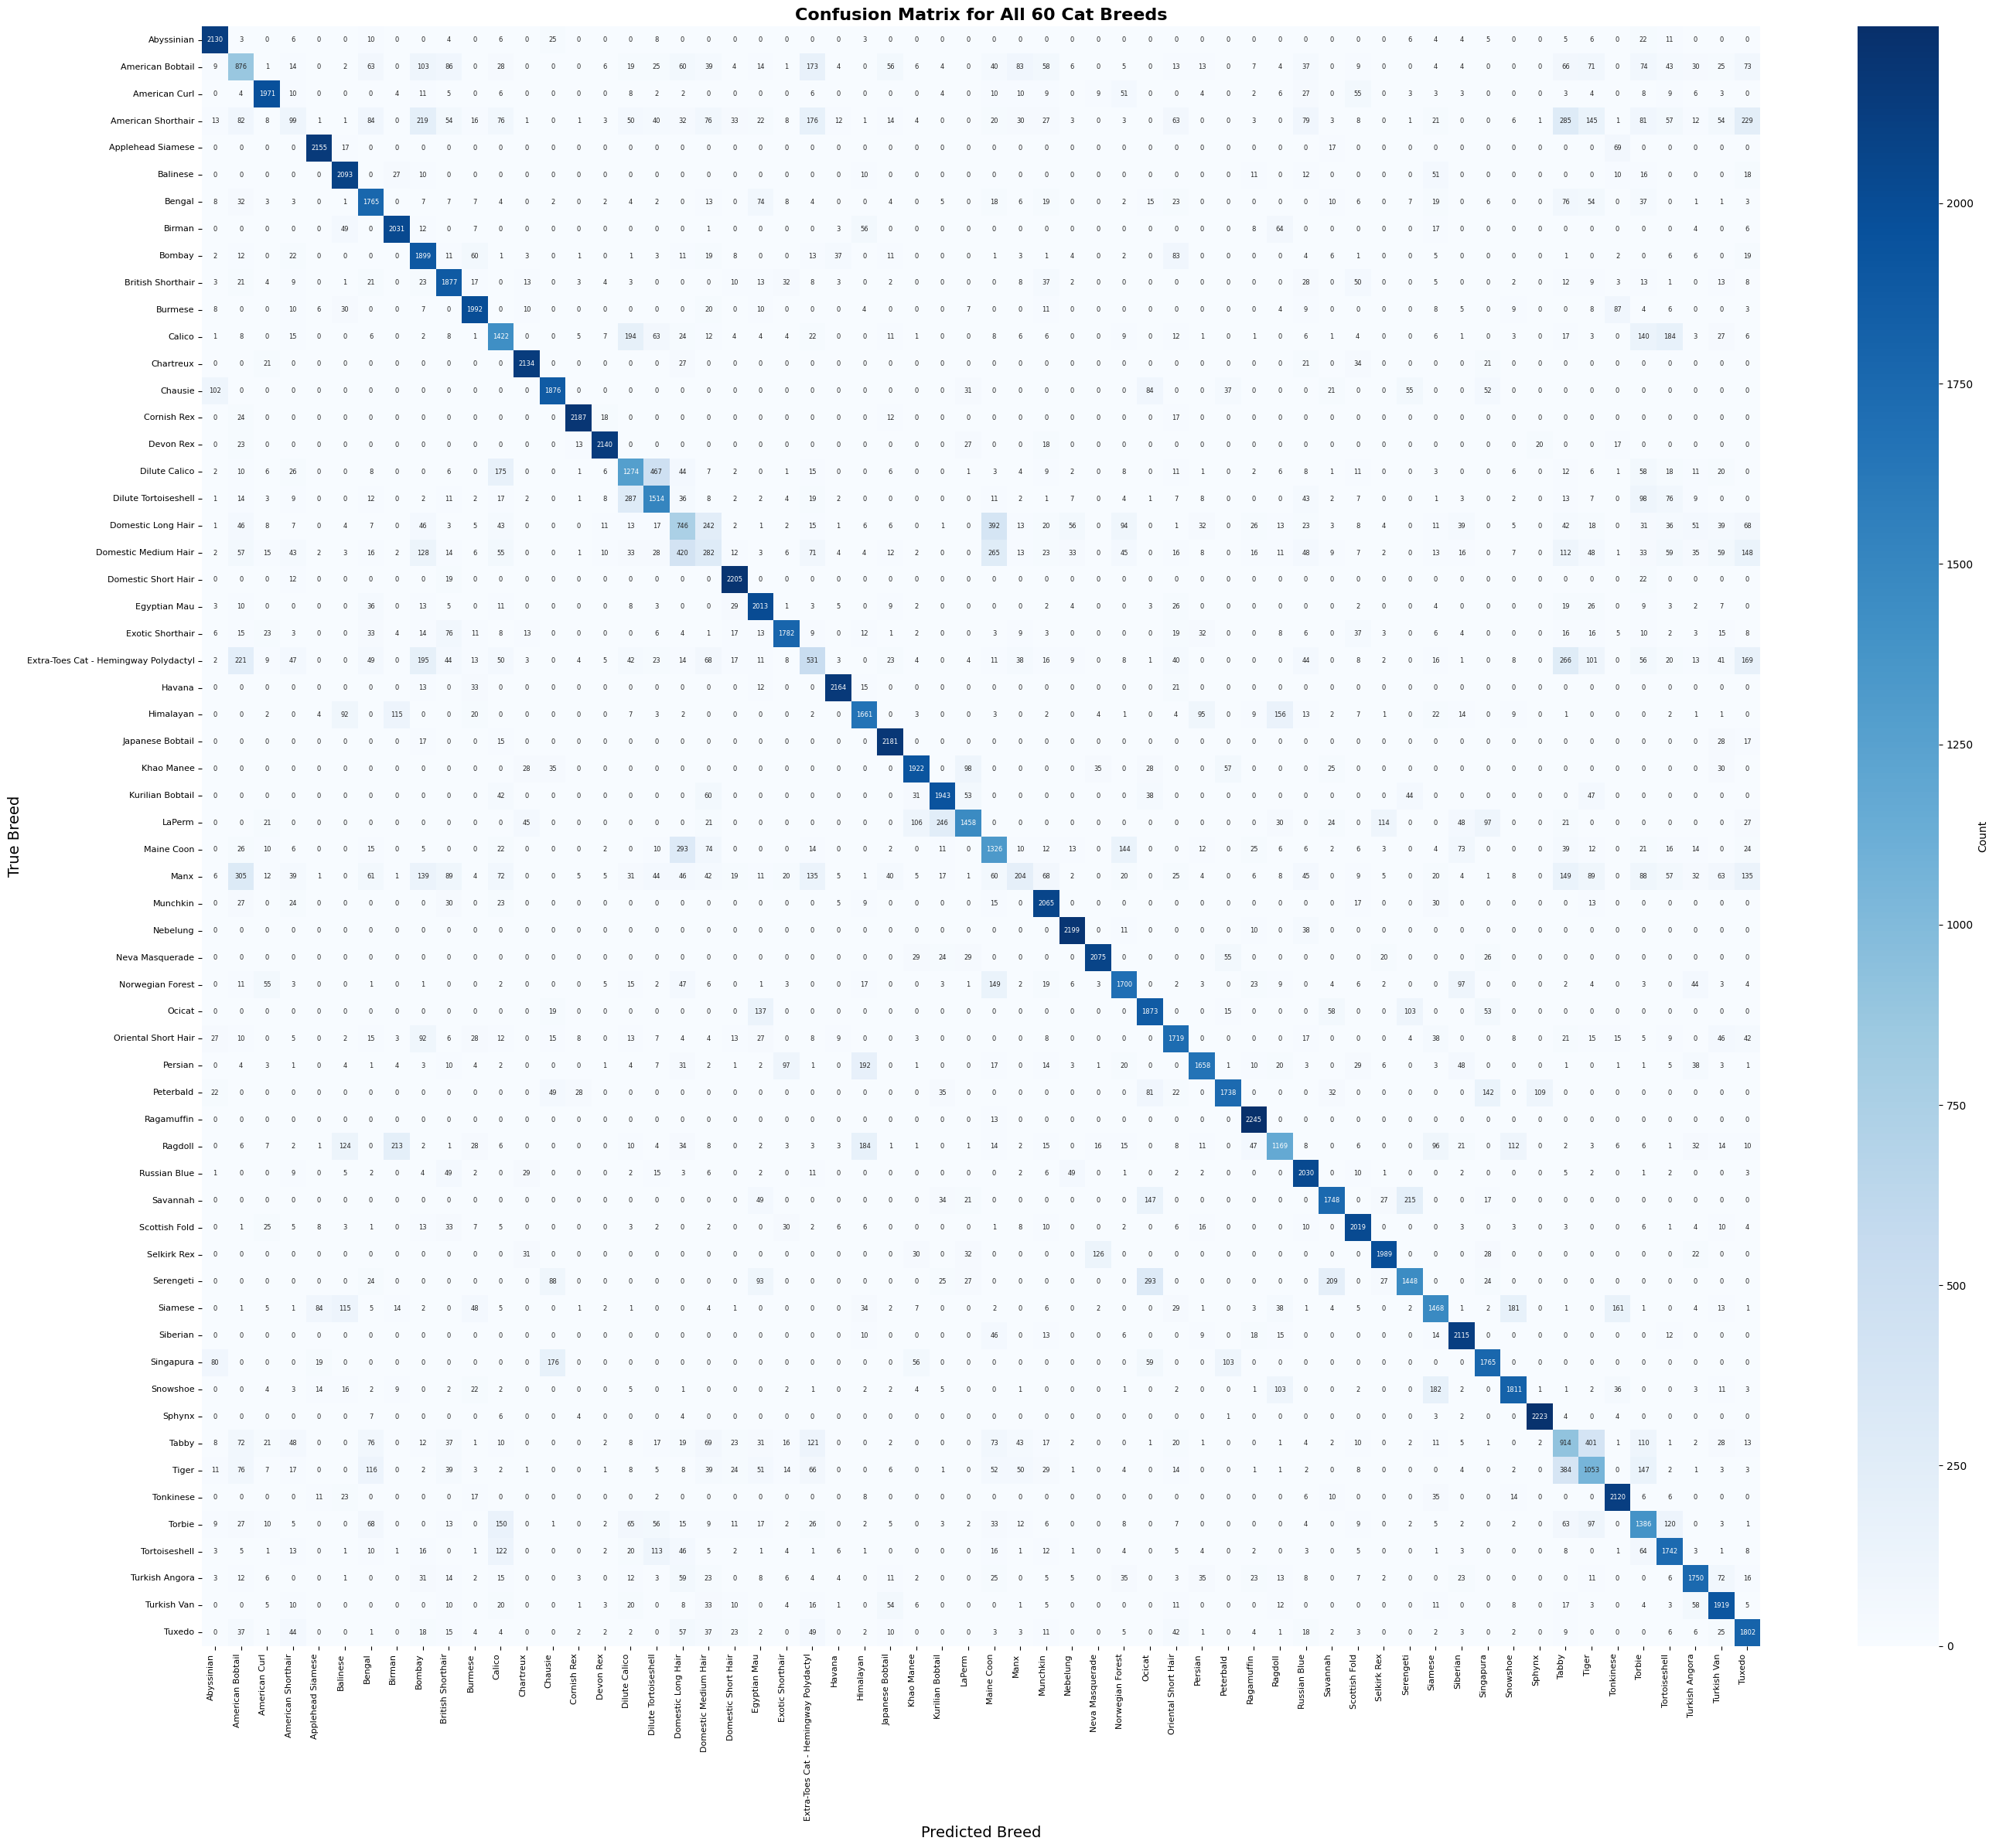


Total predictions: 135480
Correct predictions: 101596
Overall accuracy: 74.99%
Number of breeds: 60


In [200]:
# Generate confusion matrix for ALL breeds (60 total)
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Use all predictions (no filtering)
# Map labels to breed names
true_names = [id2label[idx] for idx in true_labels]
pred_names = [id2label[idx] for idx in pred_labels]

# Get all breed labels in sorted order
all_breeds_sorted = sorted(list(set(true_names)))

# Create confusion matrix
cm = confusion_matrix(true_names, pred_names, labels=all_breeds_sorted)

# Plot confusion matrix with larger figure for 60 breeds
plt.figure(figsize=(28, 24))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=all_breeds_sorted, yticklabels=all_breeds_sorted,
            cbar_kws={'label': 'Count'},
            annot_kws={'size': 6})  # Smaller annotation font for readability
plt.xlabel('Predicted Breed', fontsize=14)
plt.ylabel('True Breed', fontsize=14)
plt.title(f'Confusion Matrix for All {len(all_breeds_sorted)} Cat Breeds', fontsize=16, fontweight='bold')
plt.xticks(rotation=90, ha='right', fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.tight_layout()
plt.show()

print(f"\nTotal predictions: {len(true_labels)}")
print(f"Correct predictions: {np.sum(pred_labels == true_labels)}")
print(f"Overall accuracy: {np.sum(pred_labels == true_labels) / len(true_labels) * 100:.2f}%")
print(f"Number of breeds: {len(all_breeds_sorted)}")

In [204]:
# Analyze What Low Accuracy Breeds Are Being Confused With
print("\n" + "="*70)
print("CONFUSION ANALYSIS FOR BREEDS WITH < 50% ACCURACY")
print("="*70)
print("Shows the TOP-1 predictions (what the model predicts as #1 choice)")
print("="*70)

# Get breeds with accuracy < 20%
low_accuracy_breeds = []
for breed in sorted(breed_total.keys()):
    accuracy = breed_correct[breed] / breed_total[breed] * 100
    if accuracy < 20:
        low_accuracy_breeds.append((breed, accuracy))

if not low_accuracy_breeds:
    print("No breeds with accuracy below 20%")
else:
    # For each low accuracy breed, show what it's being confused with
    for breed, accuracy in low_accuracy_breeds:
        breed_type = "NEW" if breed in NEW_BREEDS else "ORIGINAL"
        
        # Find all test samples of this breed
        breed_indices = [i for i, label in enumerate(true_labels) if id2label[label] == breed]
        
        print(f"\n{breed} ({breed_type}) - Top-1 Accuracy: {accuracy:.2f}%")
        print(f"Total test samples: {len(breed_indices)}")
        print("-" * 70)
        
        # Count what the model predicts as #1 choice (not top-3)
        top1_predictions = defaultdict(int)
        
        for idx in breed_indices:
            # Get the TOP-1 prediction only (argmax)
            predicted_breed = id2label[pred_labels[idx]]
            top1_predictions[predicted_breed] += 1
        
        # Show most common TOP-1 predictions
        print("Most common TOP-1 predictions (what model thinks it is):")
        for predicted_breed, count in sorted(top1_predictions.items(), key=lambda x: x[1], reverse=True)[:7]:
            percentage = (count / len(breed_indices)) * 100
            is_correct = "✓ CORRECT" if predicted_breed == breed else "✗ WRONG"
            pred_type = "NEW" if predicted_breed in NEW_BREEDS else "ORIGINAL"
            print(f"  {predicted_breed:30s} [{pred_type:8s}]: {count:4d}/{len(breed_indices):4d} ({percentage:5.1f}%) {is_correct}")

print("\n" + "="*70)


CONFUSION ANALYSIS FOR BREEDS WITH < 50% ACCURACY
Shows the TOP-1 predictions (what the model predicts as #1 choice)

American Shorthair (ORIGINAL) - Top-1 Accuracy: 4.38%
Total test samples: 2258
----------------------------------------------------------------------
Most common TOP-1 predictions (what model thinks it is):
  Tabby                          [ORIGINAL]:  285/2258 ( 12.6%) ✗ WRONG
  Tuxedo                         [ORIGINAL]:  229/2258 ( 10.1%) ✗ WRONG
  Bombay                         [ORIGINAL]:  219/2258 (  9.7%) ✗ WRONG
  Extra-Toes Cat - Hemingway Polydactyl [ORIGINAL]:  176/2258 (  7.8%) ✗ WRONG
  Tiger                          [ORIGINAL]:  145/2258 (  6.4%) ✗ WRONG
  American Shorthair             [ORIGINAL]:   99/2258 (  4.4%) ✓ CORRECT
  Bengal                         [ORIGINAL]:   84/2258 (  3.7%) ✗ WRONG

Domestic Medium Hair (ORIGINAL) - Top-1 Accuracy: 12.49%
Total test samples: 2258
----------------------------------------------------------------------
Most co

In [198]:
print("CAT BREED MODEL - Available Classes")
print(f"Total number of cat breeds: {len(base_model.config.id2label)}")
print("\nAll cat breeds the model can predict:")
for idx, label in sorted(base_model.config.id2label.items()):
    print(f"  {idx:3d}. {label}")

CAT BREED MODEL - Available Classes
Total number of cat breeds: 60

All cat breeds the model can predict:
    0. Abyssinian
    1. American Bobtail
    2. American Curl
    3. American Shorthair
    4. Applehead Siamese
    5. Balinese
    6. Bengal
    7. Birman
    8. Bombay
    9. British Shorthair
   10. Burmese
   11. Calico
   12. Cornish Rex
   13. Devon Rex
   14. Dilute Calico
   15. Dilute Tortoiseshell
   16. Domestic Long Hair
   17. Domestic Medium Hair
   18. Domestic Short Hair
   19. Egyptian Mau
   20. Exotic Shorthair
   21. Extra-Toes Cat - Hemingway Polydactyl
   22. Havana
   23. Himalayan
   24. Japanese Bobtail
   25. Maine Coon
   26. Manx
   27. Munchkin
   28. Nebelung
   29. Norwegian Forest
   30. Oriental Short Hair
   31. Persian
   32. Ragamuffin
   33. Ragdoll
   34. Russian Blue
   35. Scottish Fold
   36. Siamese
   37. Siberian
   38. Snowshoe
   39. Sphynx
   40. Tabby
   41. Tiger
   42. Tonkinese
   43. Torbie
   44. Tortoiseshell
   45. Turkish An

# X. References

```
@dataset{almanaqibmahmooddar-37-cats-breeds-dataset,
  title={37 Cats Breeds Dataset},
  author={Almanaqib Mahmooddar},
  year={2024},
  publisher={Kaggle},
  url={https://www.kaggle.com/datasets/almanaqibmahmooddar/37-cats-breeds-dataset}
}

@misc{wesleyacheng-dog-breeds-multiclass-image-classification-with-vit,
  title={Dog Breeds Multiclass Image Classification with ViT},
  author={Wesley Acheng},
  year={2023},
  publisher={Hugging Face},
  url={https://huggingface.co/wesleyacheng/dog-breeds-multiclass-image-classification-with-vit}
}

@misc{dima806-cat-breed-image-detection,
  title={Cat Breed Image Detection},
  author={dima806},
  year={2024},
  publisher={Hugging Face},
  url={https://huggingface.co/dima806/cat_breed_image_detection}
}
```